# Damage Monitoring Tools

The damage monitoring toolkit consists the files `SectionLib.py` and `get_fibers.py`, and the Python package `opensees`. Currently these files have to be copied to the location from where they are executed, and the `opensees` package should be installed by running the following command:

```shell
pip install opensees
```

The toolkit can be used from either Tcl, Python, or directly at the command line.

The following example shows how the `get_fibers.py` module may be invoked from Tcl:

```tcl
proc py {args} {
    eval "[exec python.exe {*}$args]"
}

foreach ds {dsr1 dsr2 dsr3} {
    py get_fibers.py model.json record-${ds}.txt -e 4020,3020 -d 60 -s $ds
}
```

> Note: This currently requires the `get_fibers.py` file to be visible from the current working directory
of the Tcl interpreter.

### 1) Geometry building

Damage regions are built from the same plane geometry primitives that are offered by OpenSees (e.g. the `patch` and `layer` commands).

Additionally, the function `section` from the module `opensees.render.mpl` can be used to visualize components.

In [1]:
from opensees import patch, layer, section
import opensees.render.mpl as render

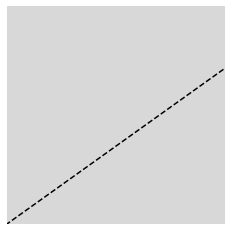

In [2]:
s = section.FiberSection(
    areas = [
        patch.circ(extRad=20, intRad=18),
        layer.line(vertices=[[-14, -10], [14, 10]]),
        patch.rect(vertices=[[-15, -10], [15, 10]])
    ]
)
render.section(s);

Print section properties:

In [3]:
print(s.area)
print(s.ixc)
print(s.iyc)
# print(s.ixc)

838.7610416728243
63215.74854278119
88215.74854278119


Additionally, the `SectionLib` module provides convenient wrappers for building  complex sections. 

The `Octagon` function from this library can be called in 3 ways:

- `ConfinedPolygon(radius)` Constructs an octagon.
- `PolygonRing(extRad, intRad, n)` Constructs an `n`-gon annulus
<!-- - `Octagon(extRad, extRad)` (ie when both arguments are equal) Constructs an octagonal boundary line. -->

In [4]:
from opensees.section import ConfinedPolygon

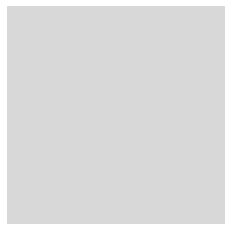

In [5]:
render.section(section.ConfinedPolygon(8, 20));

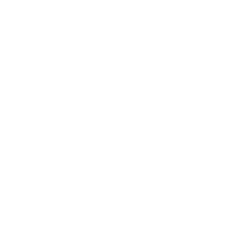

In [6]:
render.section(section.PolygonRing(8, 20, 18));

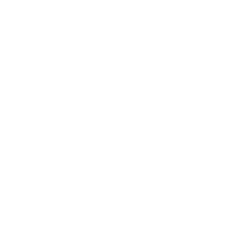

In [7]:
render.section(section.ConfinedPolygon(8, 20, 20));

### 2) Define damage state regions; the `get_fibers` module

In [8]:
from fiberRecorders import iter_elem_fibers, damage_states

The `get_fibers` module provides the helper function `iter_elem_fibers` for iterating
over a filtered collection of fibers. Fibers are filtered out by supplying a *damage state* dictionary with a required `"regions"` field, and optional `"material"` field.

In [9]:
from opensees.units.english import ft, inch

In [10]:
Dcol = 7*ft
Rcol = Dcol/2
cover = 2*inch

In [11]:
DS = damage_states(Dcol)

### 3) Iterating over fibers

In [12]:
import json
import numpy as np

In [13]:
model_file = "modelDetails.json"
elements = [4010]

In [14]:
with open(model_file, "r") as f:
    model = json.load(f)

If the third argument to `iter_elem_fibers` is omitted, all fibers are returned (Underscores are used in the following cell to name unused variables).

In [15]:
all_fibers = [
    f["coord"] for _,__,f in iter_elem_fibers(model, elements)
]

ds1_fibers = np.array([
    f["coord"] for e,s,f in iter_elem_fibers(model, elements, filt=DS["dsr1"], sections=[0])
])

ds2_fibers = np.array([
    f["coord"] for e,s,f in iter_elem_fibers(model, elements, filt=DS["dsr2"], sections=[0])
])

ds3_fibers = np.array([
    f["coord"] for e,s,f in iter_elem_fibers(model, elements, filt=DS["dsr3"], sections=[0])
])

ds4_fibers = np.array([
    f["coord"] for e,s,f in iter_elem_fibers(model, elements, filt=DS["dsr3"], sections=[0])
])



## 3) Visualizing

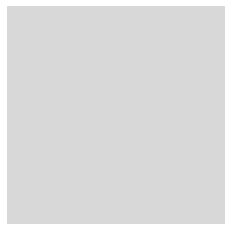

In [16]:
sect = section.ConfinedPolygon(8, Dcol/2)
ax = render.section(sect)
render.section(DS["dsr1"]["regions"][0], facecolor="b", ax=ax)
render.section(DS["dsr2"]["regions"][0], facecolor="pink", ax=ax)
render.section(DS["dsr3"]["regions"][0], facecolor="y", ax=ax)
render.section(DS["dsr4"]["regions"][0], facecolor="g", ax=ax);
render.section(DS["dsr5"]["regions"][0], facecolor="r", ax=ax);
# ax.set_xlim([0, Rcol+1])
# ax.set_ylim([-1, Rcol+1])

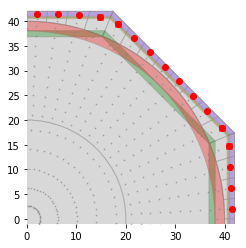

In [17]:
# Create grid of points
import numpy as np

# Create plot axis and add sections to it
ax = render.section(sect)
render.section(DS["dsr1"]["regions"][0], facecolor="b", ax=ax)
render.section(DS["dsr2"]["regions"][0], facecolor="pink", ax=ax)
render.section(DS["dsr3"]["regions"][0], facecolor="y", ax=ax)
render.section(DS["dsr4"]["regions"][0], facecolor="g", ax=ax);
render.section(DS["dsr5"]["regions"][0], facecolor="r", ax=ax);

# add filtered fibers to plot
ax.scatter(*list(zip(*all_fibers)), color="grey", alpha=0.3, s=0.5);
ax.scatter(*list(zip(*ds1_fibers)), marker=".", color="blue")
ax.scatter(*list(zip(*ds2_fibers)), color="r", marker="o")#, s=0.8)
ax.scatter(*list(zip(*ds3_fibers)), color="r", marker="x")#,  s=1)
ax.scatter(*list(zip(*ds4_fibers)), color="r", marker="+")#,  s=1)

# Set plot limits
ax.set_xlim([ 0, Rcol+1])
ax.set_ylim([-1, Rcol+1])
ax.axis("on");

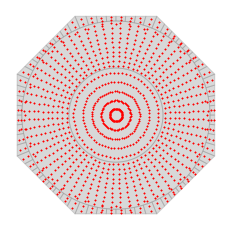

In [18]:
ax = render.section(sect)
ax.scatter(*list(zip(*all_fibers)), color="red", s=0.5);

In [60]:
def fiber_strain(recorder_data, el, s, f, t=None):
    if t is not None:
        eps = recorder_data[str(el)][str(s)]["eps"][t]
        kz =  recorder_data[str(el)][str(s)]["kappaZ"][t]
        ky =  recorder_data[str(el)][str(s)]["kappaY"][t]
    else:
        eps = recorder_data[str(el)][str(s)]["eps"]
        kz =  recorder_data[str(el)][str(s)]["kappaZ"]
        ky =  recorder_data[str(el)][str(s)]["kappaY"]

    return eps - kz * f["coord"][1] + ky * f["coord"][0]

In [61]:
import os
from pathlib import Path
userHome = Path(os.path.expanduser("~"))

dataDir    = userHome/"brace"/"Caltrans"/"Caltrans.Hayward"/"Procedures"/"datahwd12.1"
xmlName    = dataDir/ "SectionDeformationHist.xml"
# xmlNameFib = dataDir/ "DynResponse"/ "LS7Top1.xml"
jsonName   = dataDir/ "modelDetails.json"

In [62]:
recorder_data = read_sect_xml(xmlName)

[fiber_strain(recorder_data, "4020", "4", f, 0) for e,s,f in iter_elem_fibers(model, [4020])]

[-4.3800229970000014e-15,
 -2.7063831623000005e-14,
 -4.9575951400999997e-14,
 -7.1699547647e-14,
 -9.322177924850002e-14,
 -1.1393497519300003e-13,
 -1.3363968175650001e-13,
 -1.52146531324e-13,
 -1.69277982325e-13,
 -1.8486733234950001e-13,
 -1.9876520101950003e-13,
 -2.1083773849950001e-13,
 -2.2096933095860002e-13,
 -2.2906100958735006e-13,
 -2.350358311422e-13,
 -2.3883723835474994e-13,
 -2.4042664611524995e-13,
 -2.397887308778e-13,
 -2.3693163724265e-13,
 -2.3188188298140004e-13,
 -2.2468713741050002e-13,
 -2.154180432605e-13,
 -2.0416321284050003e-13,
 -1.9103109851500002e-13,
 -1.7614750597600002e-13,
 -1.596572642135e-13,
 -1.41718593277e-13,
 -1.225038481215e-13,
 -1.0219814322899999e-13,
 -8.099724075e-14,
 -5.9105232429e-14,
 -3.6733120038e-14,
 -1.4096037002999999e-14,
 8.587771623000002e-15,
 3.1099891401e-14,
 5.322348764700001e-14,
 7.474571924850002e-14,
 9.545891519300001e-14,
 1.151636217565e-13,
 1.33670471324e-13,
 1.5080192232499998e-13,
 1.663912723495e-13,
 1.8

In [56]:
recorder_data

{'4020': {'4': {'eps': array([-9.23803e-15,  1.17006e-11,  4.85689e-11,  1.07435e-10,
           1.81814e-10,  2.72559e-10,  3.81993e-10,  5.13145e-10,
           6.68438e-10,  8.48021e-10,  1.05120e-09,  1.27690e-09,
           1.52463e-09,  1.79523e-09,  2.08957e-09,  2.40845e-09,
           2.75236e-09,  3.12226e-09,  3.51906e-09,  3.94336e-09,
           4.39410e-09,  4.87250e-09,  5.37882e-09,  5.90818e-09,
           6.45472e-09]),
   'kappaZ': array([8.65365e-14, 7.65277e-13, 2.25510e-12, 4.50520e-12, 7.44657e-12,
          1.10833e-11, 1.54277e-11, 2.05259e-11, 2.64177e-11, 3.31129e-11,
          4.05945e-11, 4.88495e-11, 5.78777e-11, 6.76917e-11, 7.83332e-11,
          8.98398e-11, 1.02211e-10, 1.15468e-10, 1.29630e-10, 1.44654e-10,
          1.60533e-10, 1.77298e-10, 1.94906e-10, 2.13202e-10, 2.31962e-10]),
   'kappaY': array([ 6.07595e-15,  8.49774e-14,  3.43475e-13,  7.52029e-13,
           1.21800e-12,  1.71340e-12,  2.23688e-12,  2.79077e-12,
           3.35273e-12,  3.90

2256